In [1]:
# ========= 可调参数 =========
HIDDEN       = 2048          # 隐藏层神经元
NUM_LAYERS   = 3             # 隐藏层数（不含输出层）
DROPOUT      = 0.1           # dropout 概率
LR           = 1e-3          # 初始学习率
BATCH        = 128           # batch size
MAX_EPOCH    = 1000           # 最大 epoch
PATIENCE     = 1000        # 早停耐心
WEIGHT_DECAY = 1e-4          # L2 系数
# ============================

In [2]:
# data.py（官方顺序版）
import pandas as pd

url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url, skipinitialspace=True)[
    ['smiles', 'measured log solubility in mols per litre']]
df.columns = ['smiles', 'logS']
df.to_csv('data.csv', index=False)
print('data.csv ready, samples:', len(df))

data.csv ready, samples: 1128


In [3]:
import pandas as pd, numpy as np, torch, torch.nn as nn
from rdkit.Chem import MolFromSmiles, rdFingerprintGenerator
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('./data.csv')
smiles, y = df.smiles.values, df.logS.values.astype(np.float32)

def feat(s):
    mol = MolFromSmiles(s)
    if mol is None:
        return np.zeros(2048, dtype=np.float32)
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    return np.array(gen.GetFingerprint(mol), dtype=np.float32)

X = np.vstack([feat(s) for s in smiles])
n = len(X)
train_cut = int(0.8 * n); val_cut = int(0.9 * n)
X_train, y_train = X[:train_cut], y[:train_cut]
X_val,   y_val   = X[train_cut:val_cut], y[train_cut:val_cut]
X_test,  y_test  = X[val_cut:], y[val_cut:]

def loader(X, y, batch=BATCH, shuffle=True):
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(y)),
        batch_size=batch, shuffle=shuffle)
train_loader = loader(X_train, y_train)
val_loader   = loader(X_val, y_val, shuffle=False)

In [4]:
class MLP(nn.Module):
    def __init__(self, n_in=2048, hidden=HIDDEN, n_layers=NUM_LAYERS, drop=DROPOUT, wd=WEIGHT_DECAY):
        super().__init__()
        layers = [nn.Linear(n_in, hidden), nn.ReLU(), nn.Dropout(drop)]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop)]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)
        self.wd = wd
    def forward(self, x): return self.net(x).squeeze(1)
    def l2(self):
        return sum(p.pow(2).sum() for p in self.parameters() if p.ndim == 2)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MLP().to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=30, min_lr=1e-5)

best_val, patience_cnt = 1e6, 0
train_losses, val_losses, val_rmses = [], [], []

for epoch in range(MAX_EPOCH):
    # ---- 训练 ----
    model.train()
    train_loss = 0.
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        loss = nn.MSELoss()(model(xb), yb) 
        opt.zero_grad(); loss.backward(); opt.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(X_train)
    train_losses.append(train_loss)

    # ---- 验证 ----
    model.eval()
    with torch.no_grad():
        y_pred_val = model(torch.tensor(X_val).to(device)).cpu()
        val_loss   = nn.MSELoss()(y_pred_val, torch.tensor(y_val)).item()
        val_rmse   = root_mean_squared_error(y_val, y_pred_val)
    val_losses.append(val_loss); val_rmses.append(val_rmse)

    scheduler.step(val_loss)

    # 早停
    if val_rmse < best_val - 1e-4:
        best_val, patience_cnt = val_rmse, 0
        torch.save(model.state_dict(), './best_esol.pt')
    else:
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print('Early stop @', epoch); break

    if epoch % 20 == 0:
        print(f'Epoch {epoch:3d} | train Loss {train_loss:.3f} | val RMSE {val_rmse:.3f}')

Epoch   0 | train Loss 7.509 | val RMSE 2.162
Epoch  20 | train Loss 0.196 | val RMSE 1.175
Epoch  40 | train Loss 0.164 | val RMSE 1.162
Epoch  60 | train Loss 0.150 | val RMSE 1.253
Epoch  80 | train Loss 0.243 | val RMSE 1.195
Epoch 100 | train Loss 0.211 | val RMSE 1.178
Epoch 120 | train Loss 0.093 | val RMSE 1.161
Epoch 140 | train Loss 0.094 | val RMSE 1.152
Epoch 160 | train Loss 0.105 | val RMSE 1.157
Epoch 180 | train Loss 0.088 | val RMSE 1.150
Epoch 200 | train Loss 0.092 | val RMSE 1.147
Epoch 220 | train Loss 0.086 | val RMSE 1.158
Epoch 240 | train Loss 0.085 | val RMSE 1.158
Epoch 260 | train Loss 0.085 | val RMSE 1.160
Epoch 280 | train Loss 0.089 | val RMSE 1.156
Epoch 300 | train Loss 0.083 | val RMSE 1.156
Epoch 320 | train Loss 0.089 | val RMSE 1.159
Epoch 340 | train Loss 0.084 | val RMSE 1.160
Epoch 360 | train Loss 0.089 | val RMSE 1.160
Epoch 380 | train Loss 0.084 | val RMSE 1.157
Epoch 400 | train Loss 0.083 | val RMSE 1.153
Epoch 420 | train Loss 0.086 | val

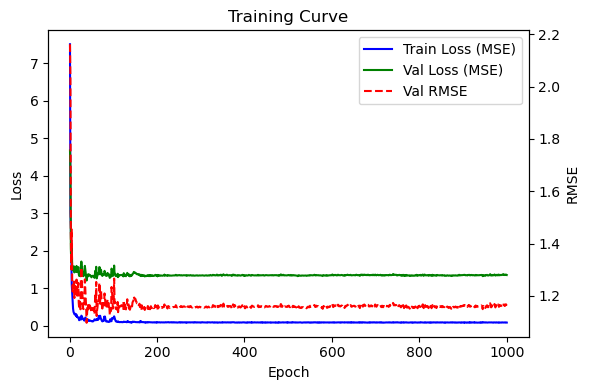

In [6]:
plt.figure(figsize=(6,4))
epochs = range(1, len(train_losses)+1)

# 左轴：Loss
ax1 = plt.gca()
ln1 = ax1.plot(epochs, train_losses, 'b-',  label='Train Loss (MSE)')[0]
ln2 = ax1.plot(epochs, val_losses,   'g-',  label='Val Loss (MSE)')[0]
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')

# 右轴：RMSE
ax2 = ax1.twinx()
ln3 = ax2.plot(epochs, val_rmses, 'r--', label='Val RMSE')[0]
ax2.set_ylabel('RMSE')

# 合并图例
lines = [ln1, ln2, ln3]
labs  = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='upper right', frameon=True)
# 若仍重叠，可微调位置：loc=(0.98, 0.98) + bbox_to_anchor
plt.title('Training Curve')
plt.tight_layout()
plt.show()

Test RMSE: 1.0973844528198242
Test R²  : 0.6932799816131592


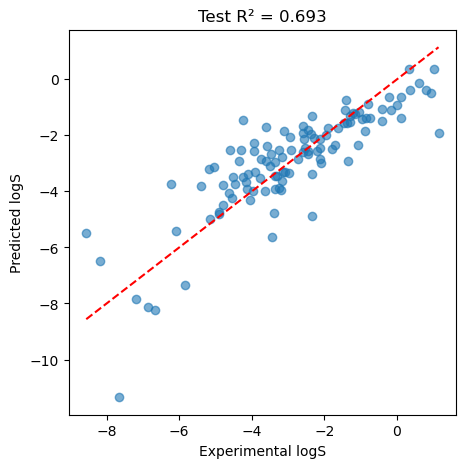

In [7]:
model.load_state_dict(torch.load('./best_esol.pt', map_location=device, weights_only=True))
model.eval()
with torch.no_grad():
    y_pred_test = model(torch.tensor(X_test).to(device)).cpu().numpy()

print('Test RMSE:', root_mean_squared_error(y_test, y_pred_test))
print('Test R²  :', r2_score(y_test, y_pred_test))

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Experimental logS'); plt.ylabel('Predicted logS')
plt.title(f'Test R² = {r2_score(y_test, y_pred_test):.3f}')
plt.show()

In [9]:
# ========== 预测单个/批量 SMILES 的 logS ==========
import torch, numpy as np
from rdkit.Chem import MolFromSmiles, rdFingerprintGenerator

# 1. 加载模型（与训练时同架构）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(n_in=2048, hidden=HIDDEN, n_layers=NUM_LAYERS, drop=0.0).to(device)  # 推理时 dropout=0
model.load_state_dict(torch.load('./best_esol.pt', map_location=device, weights_only=True))
model.eval()

# 2. 指纹生成器（与训练一致）
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_fp(smi):
    mol = MolFromSmiles(smi)
    if mol is None:
        return np.zeros(2048, dtype=np.float32)
    return np.array(fp_gen.GetFingerprint(mol), dtype=np.float32)

def predict_logS(smiles_list):
    """输入：列表 of SMILES；输出：对应 logS 数组"""
    X = np.vstack([smiles_to_fp(s) for s in smiles_list])
    with torch.no_grad():
        preds = model(torch.tensor(X).to(device)).cpu().numpy()
    return preds

# 3. 交互式输入
if __name__ == '__main__':
    user_in = input("请输入 SMILES（多个用空格或逗号分隔）：").strip()
    smi_list = [s.strip() for s in user_in.replace(',', ' ').split()]
    logS = predict_logS(smi_list)
    print('\n预测结果（水溶解度，logS mol/L）：')
    for s, ls in zip(smi_list, logS):
        print(f"{s:40s}  {ls:+.3f}")


预测结果（水溶解度，logS mol/L）：
OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O  -0.829
